In [3]:
#### stations containing observations for at least 1 year (excluding outliers less than 50 kge/nse)


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63996983/ipykernel_4111126/246027972.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


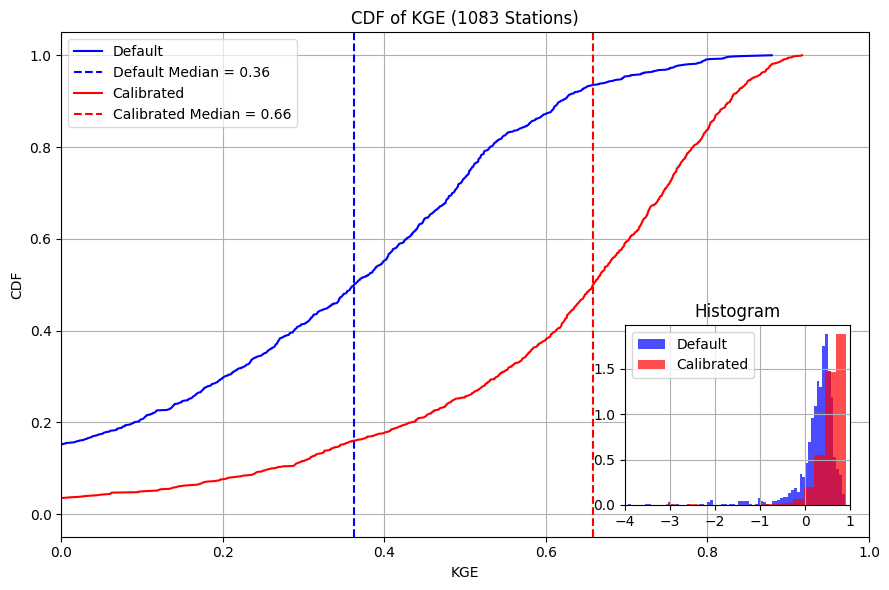

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# File paths
statistics_folder = "/ec/res4/hpcperm/ecmv6565/timeseries_stations"    ##### change it to the folder where you saved the statistics 
statistics_files = [
    "statistics_calibrated_p3.csv",
    #"statistics_calibrated_p24.csv",                                 #### make sure the file name are the same as in your folder
    #"statistics_default_p24.csv",
    "statistics_default_p3.csv",
]
outlets_file = "/home/ecm2892/repos/probation_tasks/MediumRangeEfas/outlets.csv"   ### folder which have the meta data to extract the geographical data  

# Read outlets file
outlets_data = pd.read_csv(outlets_file)
outlets_data = outlets_data[["ObsID", "StationLat", "StationLon", "DrainingArea.km2.LDD", "EC_calib"]]

# Function to process and merge data on the fly
def load_and_merge_data(filename):
    file_path = os.path.join(statistics_folder, filename)
    data = pd.read_csv(file_path)
    merged_data = data.merge(outlets_data, left_on="Station", right_on="ObsID", how="left")
    return merged_data

# Function to plot CDF with a histogram subplot
def plot_cdf_with_histogram(default_data, calibrated_data, column, metric_name, filename, calib=False):
    if calib:
        default_data = default_data[default_data['EC_calib'] > 0]
        calibrated_data = calibrated_data[calibrated_data['EC_calib'] > 0]
    
    default_data = default_data[default_data[column] >= -50]
    calibrated_data = calibrated_data[calibrated_data[column] >= -50]
    
    sorted_default = np.sort(default_data[column])
    y_default = np.arange(1, len(sorted_default) + 1) / len(sorted_default)
    median_default = np.median(sorted_default)
    num_stations_default = len(sorted_default)
    
    sorted_calibrated = np.sort(calibrated_data[column])
    y_calibrated = np.arange(1, len(sorted_calibrated) + 1) / len(sorted_calibrated)
    median_calibrated = np.median(sorted_calibrated)
    num_stations_calibrated = len(sorted_calibrated)
    
    fig, ax_cdf = plt.subplots(figsize=(9, 6))
    ax_cdf.plot(sorted_default, y_default, label='Default', color='blue')
    ax_cdf.axvline(x=median_default, color='blue', linestyle='--', label=f'Default Median = {median_default:.2f}')
    
    ax_cdf.plot(sorted_calibrated, y_calibrated, label='Calibrated', color='red')
    ax_cdf.axvline(x=median_calibrated, color='red', linestyle='--', label=f'Calibrated Median = {median_calibrated:.2f}')
    
    ax_cdf.set_xlim(0, 1)
    ax_cdf.set_xlabel(metric_name)
    ax_cdf.set_ylabel('CDF')
    ax_cdf.set_title(f'CDF of {metric_name} ({num_stations_default} Stations)')
    ax_cdf.legend(loc='upper left', framealpha=0.7)
    ax_cdf.grid()
    
    ax_hist = fig.add_axes([0.7, 0.15, 0.25, 0.3])
    ax_hist.hist(default_data[column], bins=160, alpha=0.7, label='Default', color='blue', density=True)
    ax_hist.hist(calibrated_data[column], bins=160, alpha=0.7, label='Calibrated', color='red', density=True)
    ax_hist.set_xlim(-4, 1)
    ax_hist.set_title('Histogram')
    ax_hist.legend()
    ax_hist.grid()
    
    plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

# Load and merge data dynamically
default_data = load_and_merge_data("statistics_default_p3.csv")
calibrated_data = load_and_merge_data("statistics_calibrated_p3.csv")

# Plot CDF with histogram for KGE
calib = True     # to plot for the calibration stations only 
plot_cdf_with_histogram(default_data, calibrated_data, 'KGE', 'KGE', 'cdf_kge_histogram_3p.png', calib)


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63650456/ipykernel_1513996/246027972.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


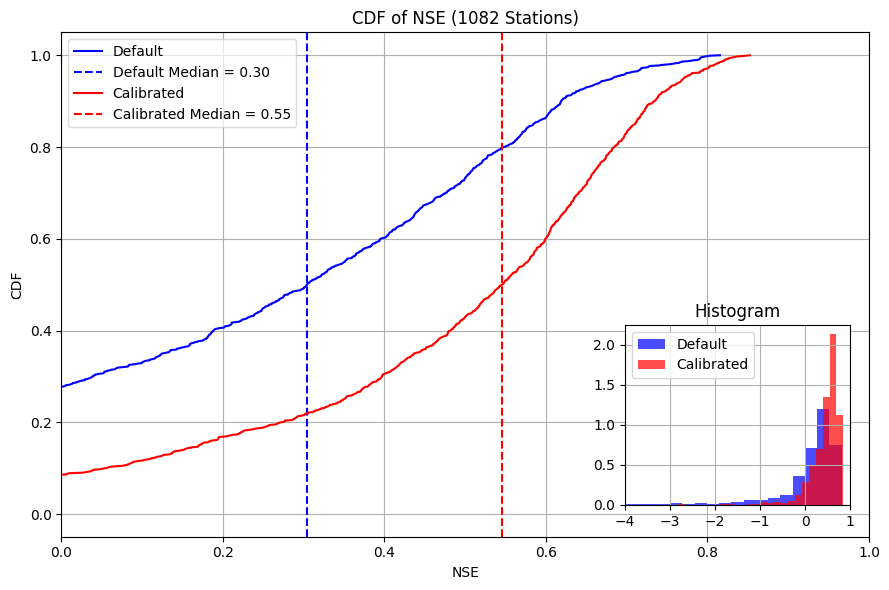

In [3]:
plot_cdf_with_histogram(default_data, calibrated_data, 'NSE', 'NSE', 'cdf_nse_histogram_3p.png', calib)

/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63650456/ipykernel_1513996/3079396137.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


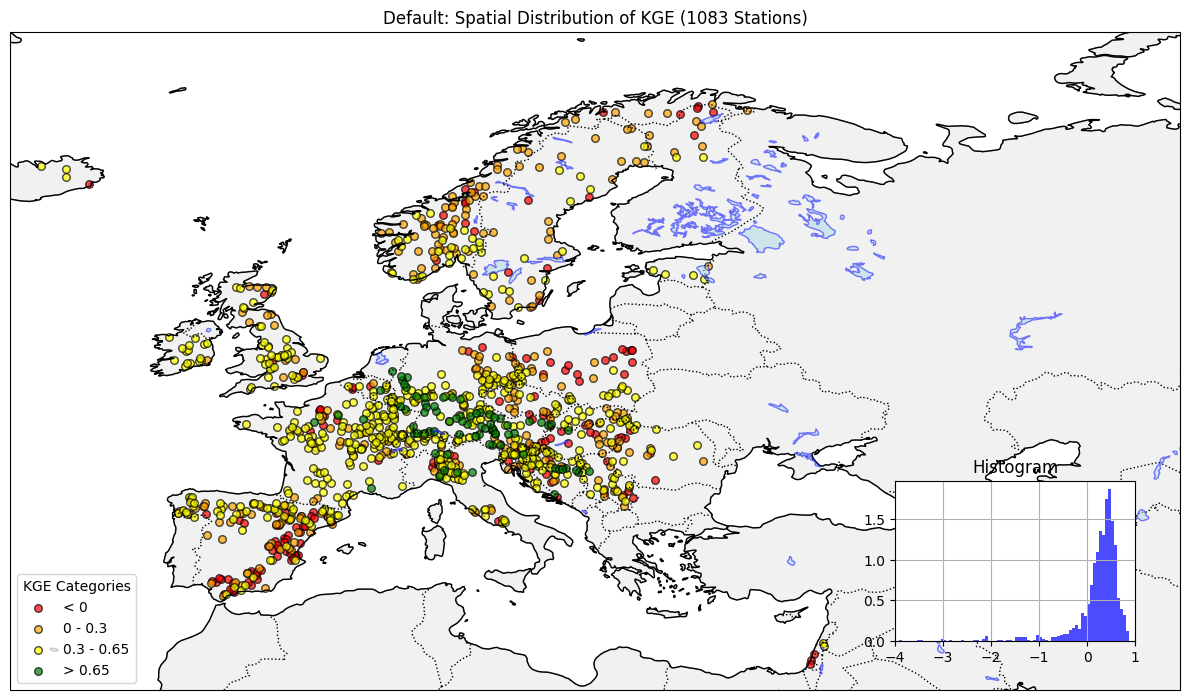

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# File paths
statistics_folder = "/ec/res4/hpcperm/ecmv6565/timeseries_stations"
outlets_file = "/home/ecm2892/repos/probation_tasks/MediumRangeEfas/outlets.csv"


# Read outlets file
outlets_data = pd.read_csv(outlets_file)
outlets_data = outlets_data[["ObsID", "StationLat", "StationLon", "DrainingArea.km2.LDD", "EC_calib"]]

# Function to process and merge data on the fly
def load_and_merge_data(filename):
    file_path = os.path.join(statistics_folder, filename)
    data = pd.read_csv(file_path)
    merged_data = data.merge(outlets_data, left_on="Station", right_on="ObsID", how="left")
    return merged_data

# Function to plot categorical spatial data with a histogram
def plot_categorical_spatial_with_histogram(data, column, metric_name, dataset_name, filename, calib=False):
    if calib:
        data = data[data['EC_calib'] > 0]
    
    data = data[data[column] >= -50]
    
    categories = [
        {'label': '< 0', 'condition': data[column] < 0, 'color': 'red'},
        {'label': '0 - 0.3', 'condition': (data[column] >= 0) & (data[column] < 0.3), 'color': 'orange'},
        {'label': '0.3 - 0.65', 'condition': (data[column] >= 0.3) & (data[column] < 0.65), 'color': 'yellow'},
        {'label': '> 0.65', 'condition': data[column] >= 0.65, 'color': 'green'}
    ]
    
    fig = plt.figure(figsize=(12, 8))
    ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax_map.set_extent([-20, 60, 30, 75], crs=ccrs.PlateCarree())
    
    ax_map.add_feature(cfeature.BORDERS, linestyle=':')
    ax_map.add_feature(cfeature.COASTLINE)
    ax_map.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', alpha=0.3)
    ax_map.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue', alpha=0.5)
    
    for category in categories:
        filtered_data = data[category['condition']]
        ax_map.scatter(
            filtered_data['StationLon'], filtered_data['StationLat'], 
            color=category['color'], label=category['label'], alpha=0.7, edgecolor='black', s=30
        )
    
    ax_map.legend(title=f'{metric_name} Categories', loc='lower left')
    ax_map.set_title(f'{dataset_name}: Spatial Distribution of {metric_name} ({len(data)} Stations)')
    
    ax_hist = fig.add_axes([0.75, 0.15, 0.2, 0.2])
    ax_hist.hist(data[column], bins=160, alpha=0.7, color='blue', density=True)
    ax_hist.set_xlim(-4, 1)
    ax_hist.set_title('Histogram')
    ax_hist.grid()
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Load and merge data dynamically
default_data = load_and_merge_data("statistics_default_p3.csv")
calibrated_data = load_and_merge_data("statistics_calibrated_p3.csv")

# Plot maps for data (KGE and NSE)
calib = True   
plot_categorical_spatial_with_histogram(default_data, 'KGE', 'KGE', 'Default', 'spatial_kge_default_categorical.png', calib)


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/3079396137.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


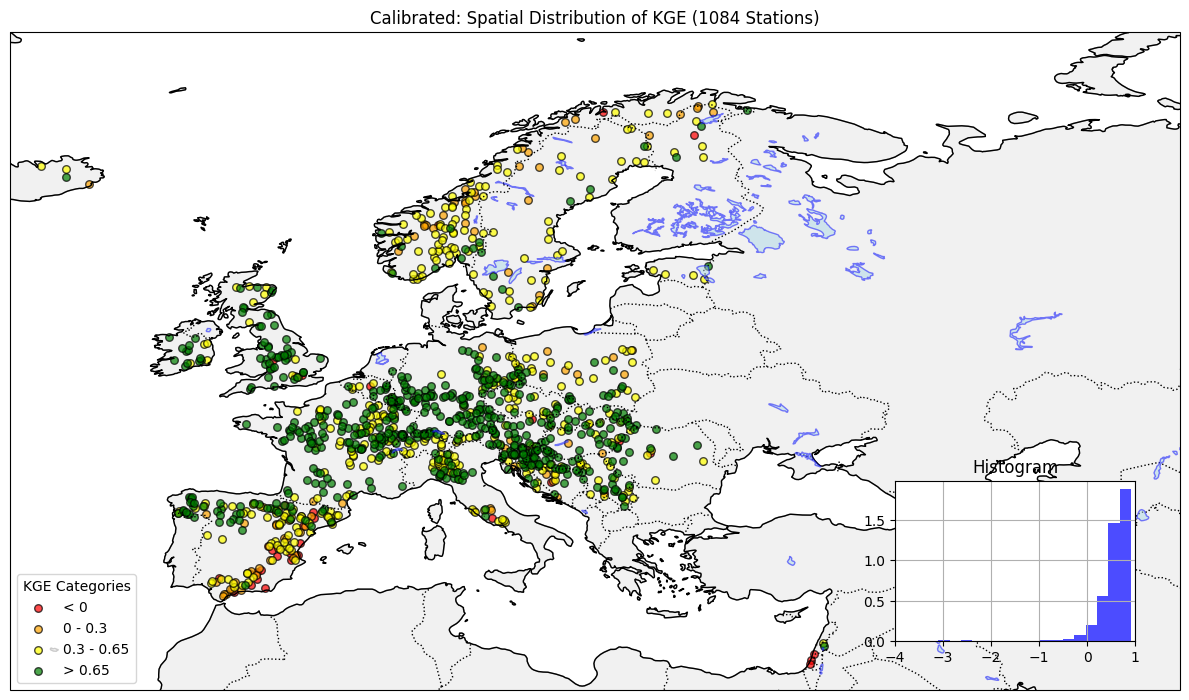

In [5]:
plot_categorical_spatial_with_histogram(calibrated_data, 'KGE', 'KGE', 'Calibrated', 'spatial_kge_calibrated_categorical_3p.png', calib )


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/3079396137.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


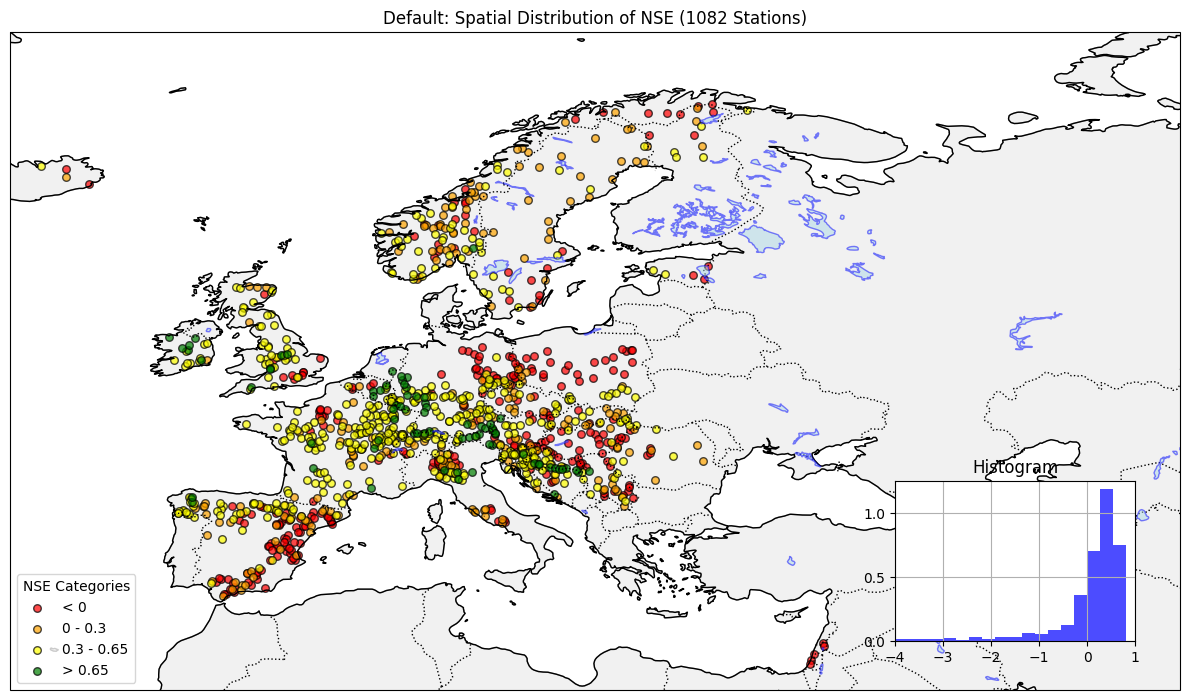

In [6]:
plot_categorical_spatial_with_histogram(default_data, 'NSE', 'NSE', 'Default', 'spatial_nse_default_categorical.png', calib )


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63650456/ipykernel_1513996/3079396137.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


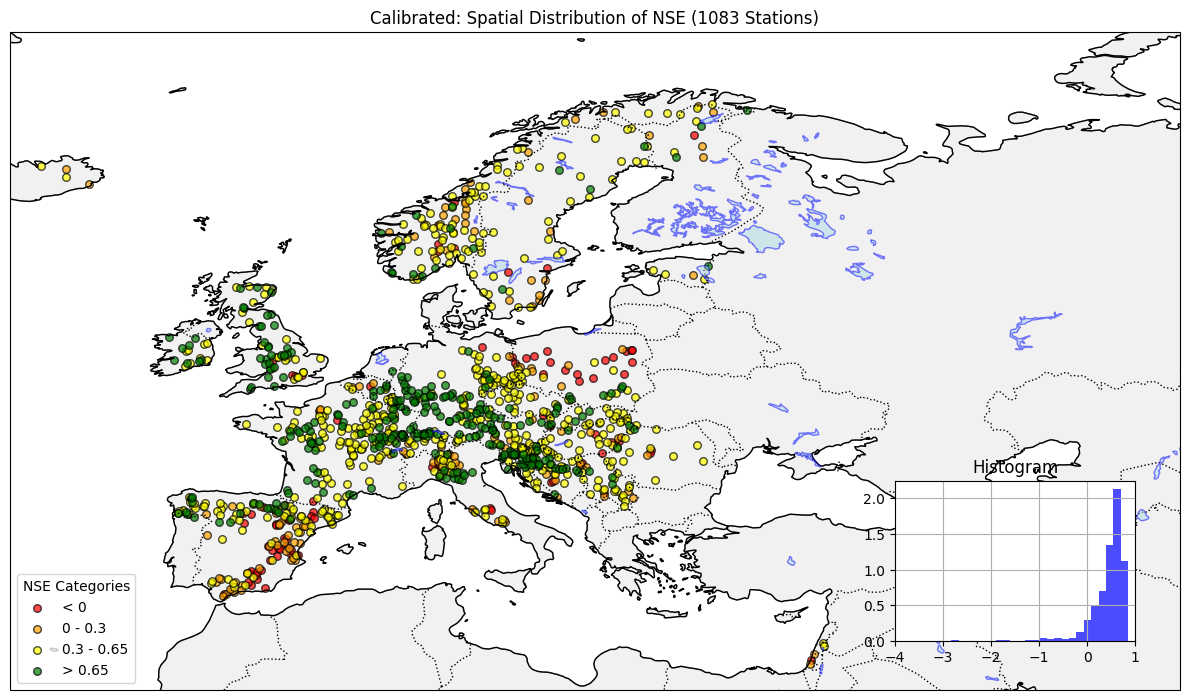

In [5]:
plot_categorical_spatial_with_histogram(calibrated_data, 'NSE', 'NSE', 'Calibrated', 'spatial_nse_default_categorical.png', calib )


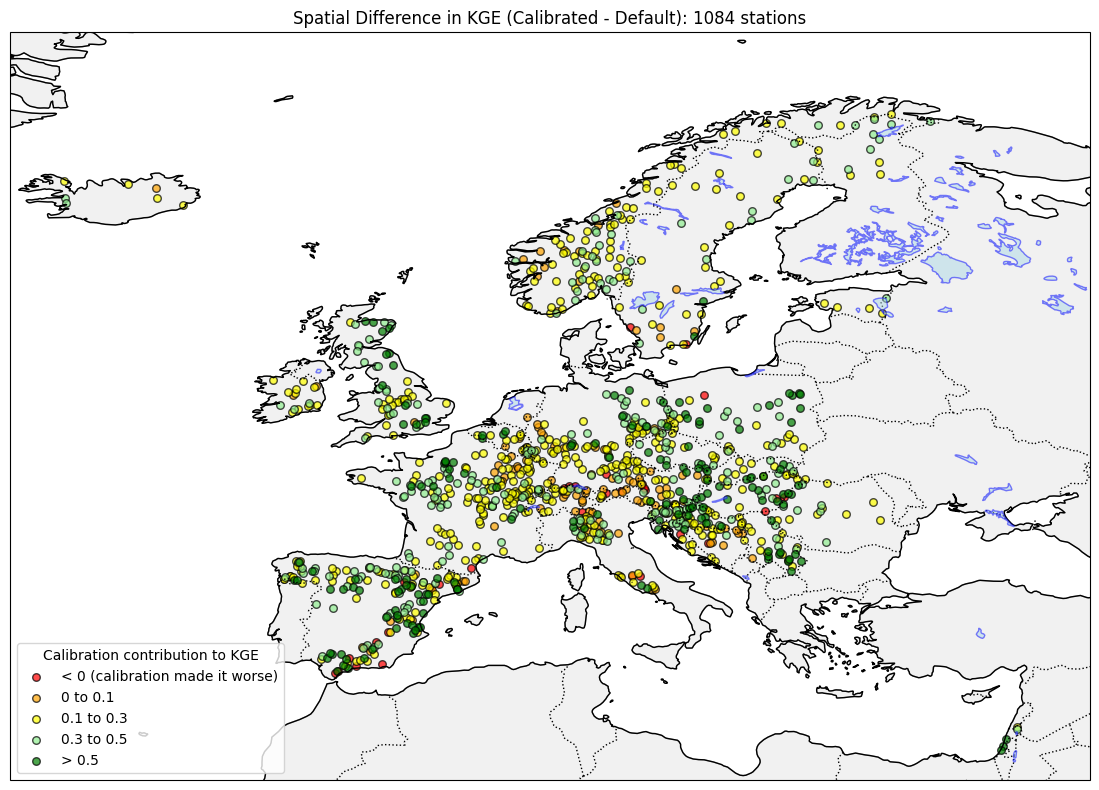

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# File paths
statistics_folder = "/ec/res4/hpcperm/ecmv6565/timeseries_stations"
outlets_file = "/home/ecm2892/repos/probation_tasks/MediumRangeEfas/outlets.csv"
#output_folder = "/ec/res4/hpcperm/ecmv6565/timeseries_stations/processed"

# Ensure output folder exists
#os.makedirs(output_folder, exist_ok=True)

# Read outlets file
outlets_data = pd.read_csv(outlets_file)
outlets_data = outlets_data[["ObsID", "StationLat", "StationLon", "DrainingArea.km2.LDD", "EC_calib"]]

# Function to process and merge data on the fly
def load_and_merge_data(filename):
    file_path = os.path.join(statistics_folder, filename)
    data = pd.read_csv(file_path)
    merged_data = data.merge(outlets_data, left_on="Station", right_on="ObsID", how="left")
    return merged_data

# Function to compute and plot spatial differences
def plot_difference_spatial(data, column_default, column_calibrated, metric_name, filename, calib=False):
    if calib:
        data = data[data['EC_calib'] > 0]
    
    data['Difference'] = data[column_calibrated] - data[column_default]
    
    categories = [
        {'label': '< 0 (calibration made it worse)', 'condition': data['Difference'] < 0, 'color': 'red'},
        {'label': '0 to 0.1', 'condition': (data['Difference'] >= 0) & (data['Difference'] < 0.1), 'color': 'orange'},
        {'label': '0.1 to 0.3', 'condition': (data['Difference'] >= 0.1) & (data['Difference'] <= 0.3), 'color': 'yellow'},
        {'label': '0.3 to 0.5', 'condition': (data['Difference'] > 0.3) & (data['Difference'] <= 0.5), 'color': 'lightgreen'},
        {'label': '> 0.5', 'condition': data['Difference'] > 0.5, 'color': 'green'}
    ]
    
    fig = plt.figure(figsize=(12, 8))
    ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax_map.set_extent([-25, 40, 30, 75], crs=ccrs.PlateCarree())
    
    ax_map.add_feature(cfeature.BORDERS, linestyle=':')
    ax_map.add_feature(cfeature.COASTLINE)
    ax_map.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', alpha=0.3)
    ax_map.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue', alpha=0.5)
    
    for category in categories:
        filtered_data = data[category['condition']]
        ax_map.scatter(
            filtered_data['StationLon'], filtered_data['StationLat'], 
            color=category['color'], label=category['label'], alpha=0.7, edgecolor='black', s=30
        )
    
    ax_map.legend(title=f'Calibration contribution to {metric_name}', loc='lower left')
    ax_map.set_title(f'Spatial Difference in {metric_name} (Calibrated - Default): {len(data)} stations')
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Load and merge data dynamically
default_data = load_and_merge_data("statistics_default_p3.csv")
calibrated_data = load_and_merge_data("statistics_calibrated_p3.csv")

# Merge the dataframes
data_merged = pd.merge(
    default_data, calibrated_data, 
    on=['Station', 'StationLon', 'StationLat', 'EC_calib'], 
    suffixes=('_default', '_calibrated')
)

# Plot spatial differences
calib = True   
plot_difference_spatial(data_merged[data_merged['KGE_default'] > -9999], 'KGE_default', 'KGE_calibrated', 'KGE', 'spatial_kge_difference.png', calib)


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/4013878613.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Difference'] = data[column_calibrated] - data[column_default]


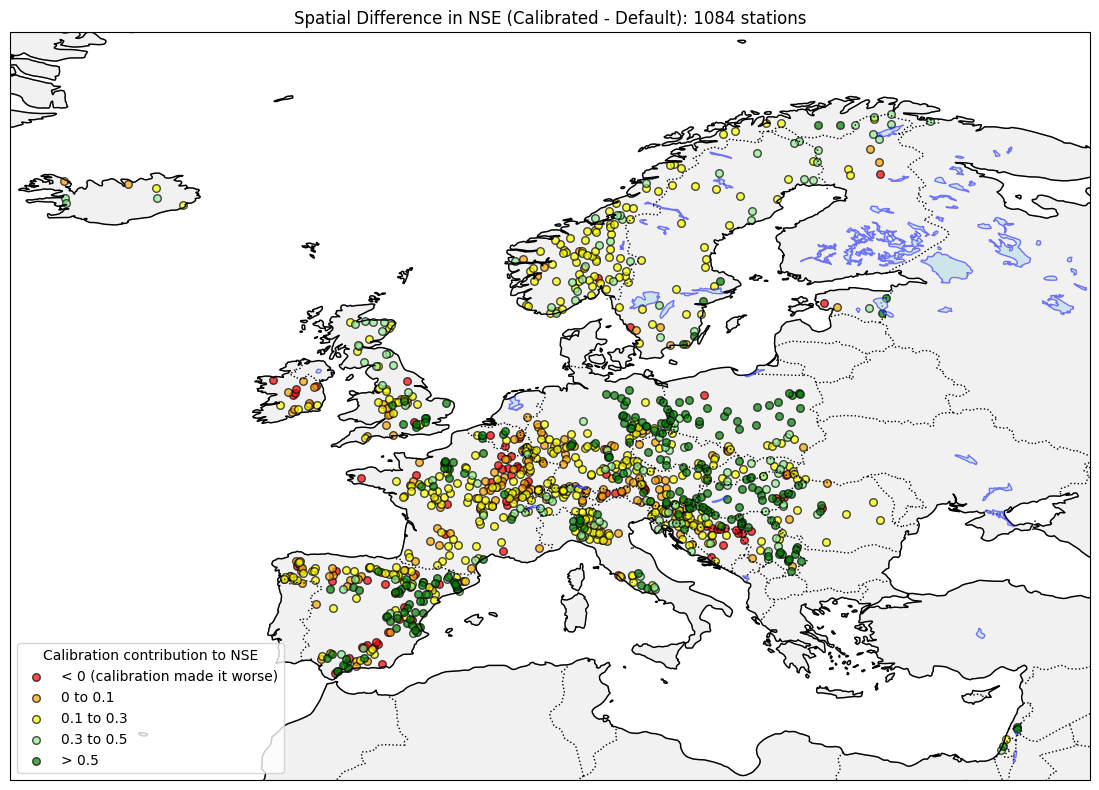

In [9]:
plot_difference_spatial(data_merged, 'NSE_default', 'NSE_calibrated', 'NSE', 'spatial_nse_difference.png', calib)

/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/1084693798.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stations = data_merged[mask][data_merged['EC_calib']>0]
/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/1084693798.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stations = data_merged[mask][data_merged['EC_calib']>0]
/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/1084693798.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stations = data_merged[mask][data_merged['EC_calib']>0]
/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63604403/ipykernel_3299338/1084693798.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stations = data_merged[mask][data_merged['EC_calib']>0]
/etc/ecmwf/s

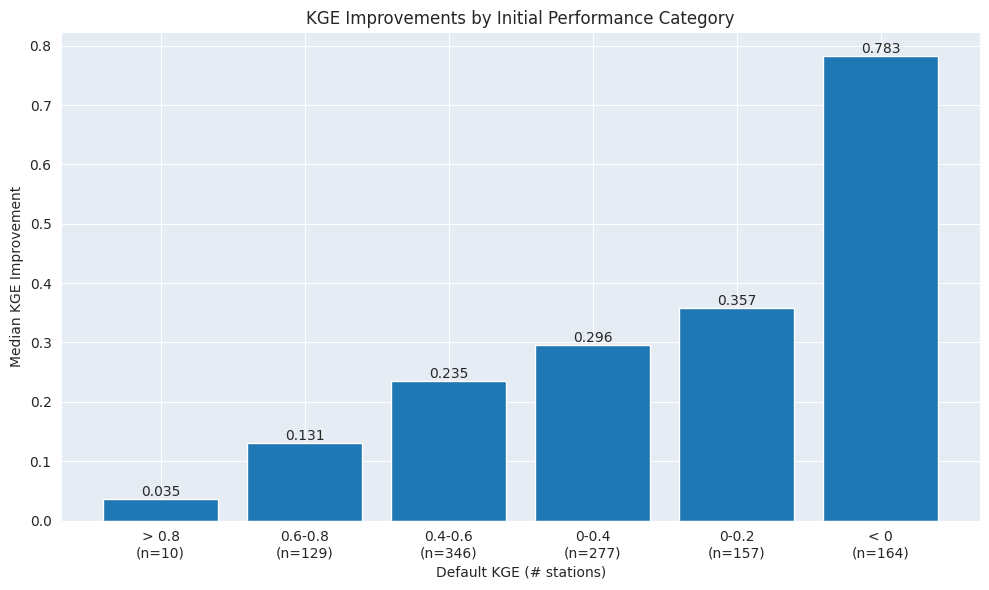

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Create bins for default KGE values and calculate statistics
categories = [
    (0.8, float('inf'), "> 0.8"),
    (0.6, 0.8, "0.6-0.8"),
    (0.4, 0.6, "0.4-0.6"),
    (0.2, 0.4, "0-0.4"),
    (0, 0.2, "0-0.2"),
    (-50, 0, "< 0")
]


medians = []
counts = []
labels = []

for lower, upper, label in categories:
   mask = (data_merged['KGE_default'] >= lower) & (data_merged['KGE_default'] < upper)
   stations = data_merged[mask][data_merged['EC_calib']>0] 
   improvement = stations['KGE_calibrated'] - stations['KGE_default']
   medians.append(improvement.median())
   counts.append(len(stations))
   labels.append(f"{label}\n(n={len(stations)})")

# Create figure


plt.figure(figsize=(10, 6))#sns.set_style("darkgrid")  # Darker grid for a professional look
background_color = "#E6ECF4"  # Light blue-gray background

ax = plt.gca()
ax.set_facecolor(background_color)  # Set background color
bars = plt.bar(labels, medians)
plt.ylabel('Median KGE Improvement')
plt.xlabel('Default KGE (# stations)')
plt.title('KGE Improvements by Initial Performance Category')
#plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for bar in bars:
   height = bar.get_height()
   plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

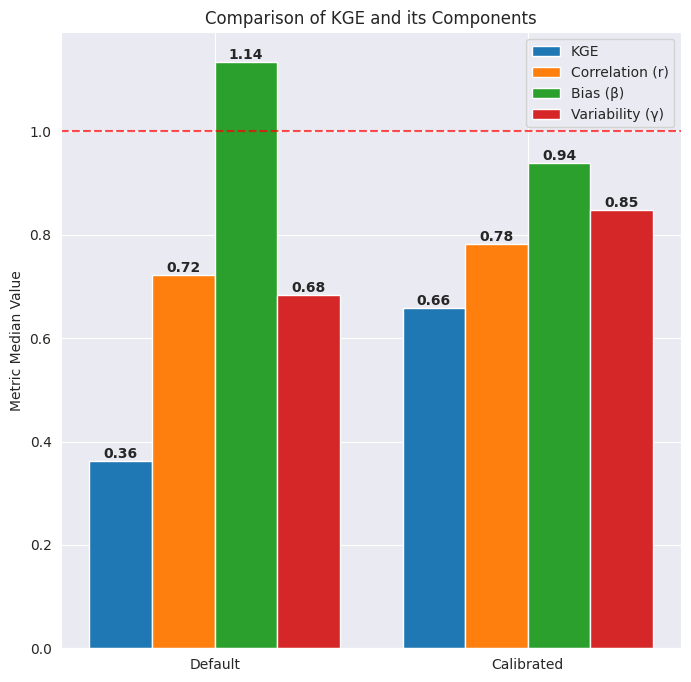

In [21]:
import matplotlib.pyplot as plt
import numpy as np
 
# Calculate medians for each component
if calib:
    kge_medians = {
       'Default': {
           'KGE': np.median(default_data['KGE'][default_data['EC_calib'] > 0]),
           'r': np.median(default_data['r'][default_data['EC_calib'] > 0]),
           'Beta': np.median(default_data['Beta'][default_data['EC_calib'] > 0]),
           'Gamma': np.median(default_data['Gamma'][default_data['EC_calib'] > 0])
       },
       'Calibrated': {
           'KGE': np.median(calibrated_data['KGE'][calibrated_data['EC_calib'] > 0]),
           'r': np.median(calibrated_data['r'][calibrated_data['EC_calib'] > 0]),
           'Beta': np.median(calibrated_data['Beta'][calibrated_data['EC_calib'] > 0]),
           'Gamma': np.median(calibrated_data['Gamma'][calibrated_data['EC_calib'] > 0])
       }
    }
else:
    kge_medians = {
       'Default': {
           'KGE': np.median(default_data['KGE']),
           'r': np.median(default_data['r']),
           'Beta': np.median(default_data['Beta']),
           'Gamma': np.median(default_data['Gamma'])
       },
       'Calibrated': {
           'KGE': np.median(calibrated_data['KGE']),
           'r': np.median(calibrated_data['r']),
           'Beta': np.median(calibrated_data['Beta']),
           'Gamma': np.median(calibrated_data['Gamma'])
       }
    }

# Categories and values
categories = ["Default", "Calibrated"]
metrics = ["KGE", "Correlation (r)", "Bias (β)", "Variability (γ)"]
values = [
    [kge_medians["Default"]["KGE"], kge_medians["Calibrated"]["KGE"]],
    [kge_medians["Default"]["r"], kge_medians["Calibrated"]["r"]],
    [kge_medians["Default"]["Beta"], kge_medians["Calibrated"]["Beta"]],
    [kge_medians["Default"]["Gamma"], kge_medians["Calibrated"]["Gamma"]]
]

# Define bar positions
x = np.arange(len(categories))  # X locations for the two main groups
width = 0.2  # Width of each bar

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot each metric as grouped bars and add text labels on top
for i, (metric, val) in enumerate(zip(metrics, values)):
    bars = ax.bar(x + (i - 1.5) * width, val, width, label=metric)  # Shift bars for grouping

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight reference line at y=1
ax.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

# Labels and titles
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel("Metric Median Value")
ax.set_title("Comparison of KGE and its Components")
ax.legend()

# Display plot
plt.show()


/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63650456/ipykernel_1513996/4263030459.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63650456/ipykernel_1513996/4263030459.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63650456/ipykernel_1513996/4263030459.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(
/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ec

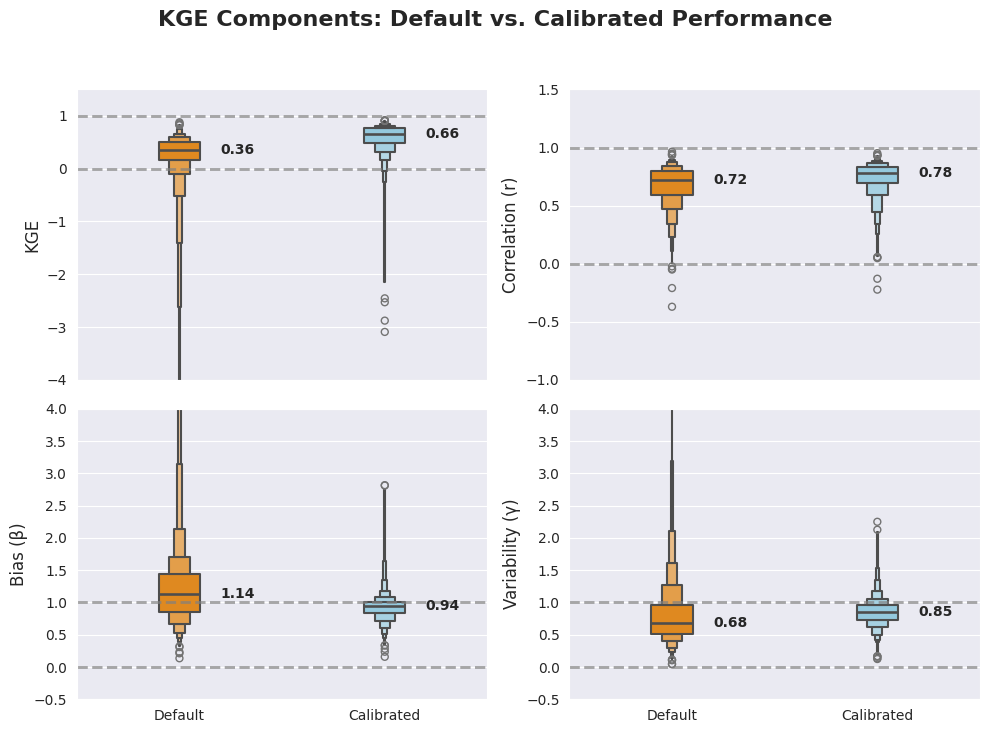

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_kge_components_comparison(default_data, calibrated_data, calib=True):
    """
    Plots KGE and its components (r, Beta, Gamma) in 4 separate subplots,
    comparing Default vs Calibrated with boxplots.
    
    Parameters:
        default_data (dict): Dictionary containing the default model metrics
        calibrated_data (dict): Dictionary containing the calibrated model metrics
        calib (bool): Whether to filter by calibration points
    """
    # Set style
    sns.set_style("darkgrid")
    
    # Create figure with 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axes = axes.flatten()  # Flatten for easier iteration
    
    # Colors for the two categories
    colors = ["#FF8C00", "skyblue"]  # Orange (Default) and Blue (Calibrated)
    
    # Metrics to plot
    metrics = ["KGE", "r", "Beta", "Gamma"]
    metric_labels = ["KGE", "Correlation (r)", "Bias (β)", "Variability (γ)"]
    
    # Define y-axis limits for each metric
    y_limits = {
        "KGE": (-4, 1.5),  # KGE typically ranges between -1 and 1
        "r": (-1, 1.5),     # Correlation (r) ranges between 0 and 1
        "Beta": (-0.5, 4),  # Bias (Beta) typically ranges between 0 and 2
        "Gamma": (-0.5, 4)  # Variability (Gamma) typically ranges between 0 and 2
    }
    
    # Create DataFrames for plotting
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        # Prepare data for current metric
        df_plot = []
        
        # Filter data based on calib flag if needed
        if calib:
            default_values = default_data[metric][default_data['EC_calib'] > 0]
            calibrated_values = calibrated_data[metric][calibrated_data['EC_calib'] > 0]
        else:
            default_values = default_data[metric]
            calibrated_values = calibrated_data[metric]
        
        # Add default values
        for val in default_values:
            df_plot.append(["Default", val])
        
        # Add calibrated values
        for val in calibrated_values:
            df_plot.append(["Calibrated", val])
        
        # Convert to DataFrame
        df_metric = pd.DataFrame(df_plot, columns=["Run Type", "Value"])
        
        # Create boxplot
        sns.boxenplot(
            data=df_metric,
            x="Run Type", 
            y="Value",
            ax=axes[i],
            palette={"Default": colors[0], "Calibrated": colors[1]},
            width=0.2,
            linewidth=1.5
        )
        
        # Calculate median values
        default_median = np.median(default_values)
        calibrated_median = np.median(calibrated_values)
        
        # Add text labels for medians - offset to the right side of each box
        axes[i].text(0 + 0.2, default_median, f'{default_median:.2f}', 
                    ha='left', va='center', fontsize=10, fontweight='bold')
        axes[i].text(1 + 0.2, calibrated_median, f'{calibrated_median:.2f}', 
                    ha='left', va='center', fontsize=10, fontweight='bold')
        
        # Set labels
        axes[i].set_ylabel(label, fontsize=12)
        axes[i].set_xlabel("")  # No x-label needed
        
        # Add reference lines at y=1 and y=0
        axes[i].axhline(y=1, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        
        # Set y-limits for the current metric
        axes[i].set_ylim(y_limits[metric])
        
    # Get legend handles from the first subplot
    handles, labels = axes[0].get_legend_handles_labels()
    
    # Add overall title
    fig.suptitle("KGE Components: Default vs. Calibrated Performance", fontsize=16, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.07, 1, 0.95])  # Make room for the title and legend
    
    return fig

# Example usage
fig = plot_kge_components_comparison(default_data, calibrated_data, calib=True)
plt.show()

In [12]:
#### SOME CORRELATION PLOTS 

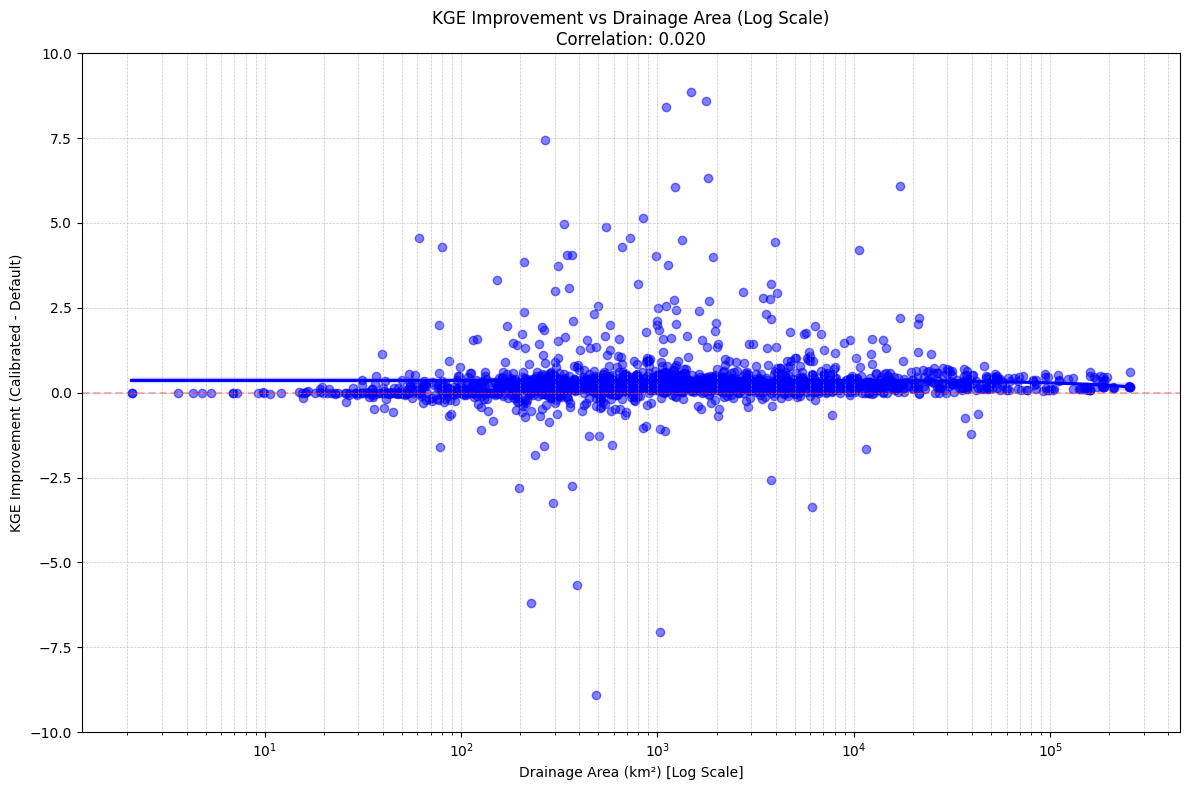

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Filter out KGE values less than -50 in both datasets
mask_default = default_data['KGE'] > -50
mask_calibrated = calibrated_data['KGE'] > -50
mask_combined = mask_default & mask_calibrated

# Apply filters to both datasets
default_filtered = default_data[mask_combined].copy()
calibrated_filtered = calibrated_data[mask_combined].copy()

# Calculate KGE improvement
default_filtered['KGE_improvement'] = calibrated_filtered['KGE'] - default_filtered['KGE']

# Create figure
plt.figure(figsize=(12, 8))

# Create scatter plot with regression line on a log scale
sns.regplot(x=default_filtered['DrainingArea.km2.LDD'], 
            y=default_filtered['KGE_improvement'],
            scatter_kws={'alpha':0.5},
            color='blue',
            label='KGE Improvement')

# Apply logarithmic scale to x-axis
plt.xscale("log")

# Calculate correlation coefficient and p-value
corr, p_value = stats.pearsonr(np.log(default_filtered['DrainingArea.km2.LDD']), 
                               default_filtered['KGE_improvement'])

plt.xlabel('Drainage Area (km²) [Log Scale]')
plt.ylabel('KGE Improvement (Calibrated - Default)')
plt.ylim(-10, 10)
plt.title(f'KGE Improvement vs Drainage Area (Log Scale)\nCorrelation: {corr:.3f}')

# Add horizontal line at y=0 to show positive/negative improvement boundary
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)

# Adjust layout
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)  # Improve grid visibility
plt.tight_layout()
plt.savefig("correlation_log.png")

# Display the plot
plt.show()


